In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('final1_train.csv')
df.head()

,Unnamed: 0,id,title,author,text,label,summary
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"[\nAs we now know, Comey notified the Republic..."
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,[Clinton described her vanquisher and his supp...
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,[So the intelligence specialists who send thei...
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,[\nThe Bureau has been able to identify 15 civ...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,[\n“When the intelligence unit of the Revoluti...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18283 entries, 0 to 18282
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18283 non-null  int64 
 1   id          18283 non-null  int64 
 2   title       18283 non-null  object
 3   author      18283 non-null  object
 4   text        18283 non-null  object
 5   label       18283 non-null  int64 
 6   summary     18283 non-null  object
dtypes: int64(3), object(4)
memory usage: 1000.0+ KB


In [5]:
df = df.drop(columns=['id', 'title', 'author','text'], axis=1)

In [6]:
df['clean_news'] = df['summary'].str.lower()
df['clean_news']

0        [\nas we now know, comey notified the republic...
1        [clinton described her vanquisher and his supp...
2        [so the intelligence specialists who send thei...
3        [\nthe bureau has been able to identify 15 civ...
4        [\n“when the intelligence unit of the revoluti...
                               ...                        
18278    [the   star of the vh1 reality show t. i.  tin...
18279    [4:40 p. m. eastern sunday on fox thanks to pl...
18280    [but the company has largely resisted more amb...
18281    [nato, russia to hold parallel exercises in ba...
18282    [children who got near this tool tended to hav...
Name: clean_news, Length: 18283, dtype: object

In [7]:
df['clean_news'] = df['clean_news'].str.replace('[^A-Za-z0-9\s]', '')
df['clean_news'] = df['clean_news'].str.replace('\n', '')
df['clean_news'] = df['clean_news'].str.replace('\s+', ' ')
df['clean_news']

0        as we now know comey notified the republican c...
1        clinton described her vanquisher and his suppo...
2        so the intelligence specialists who send their...
3        the bureau has been able to identify 15 civili...
4        when the intelligence unit of the revolutionar...
                               ...                        
18278    the star of the vh1 reality show t i tiny the ...
18279    440 p m eastern sunday on fox thanks to playin...
18280    but the company has largely resisted more ambi...
18281    nato russia to hold parallel exercises in balk...
18282    children who got near this tool tended to have...
Name: clean_news, Length: 18283, dtype: object

In [8]:
# remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))
df.head()

,Unnamed: 0,label,summary,clean_news
0,0,1,"[\nAs we now know, Comey notified the Republic...",know comey notified republican chairmen democr...
1,1,0,[Clinton described her vanquisher and his supp...,clinton described vanquisher supporters embrac...
2,2,1,[So the intelligence specialists who send thei...,intelligence specialists send usually accurate...
3,3,1,[\nThe Bureau has been able to identify 15 civ...,bureau able identify 15 civilians killed singl...
4,4,1,[\n“When the intelligence unit of the Revoluti...,intelligence unit revolutionary guards came ar...


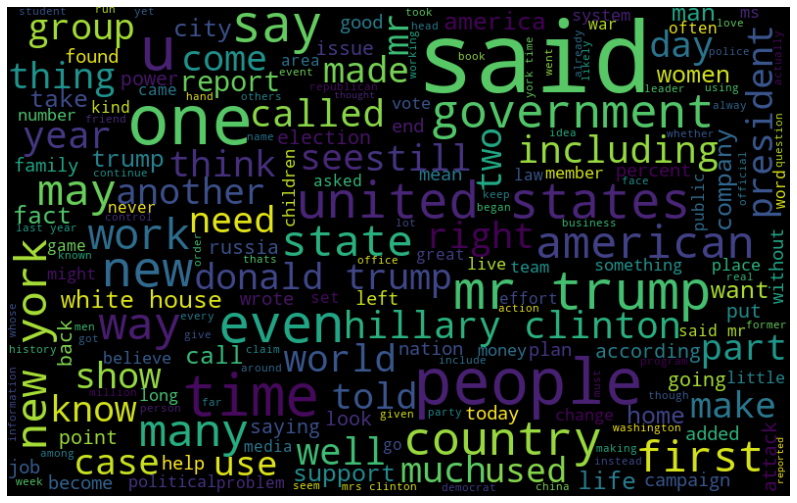

In [9]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in df['clean_news']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

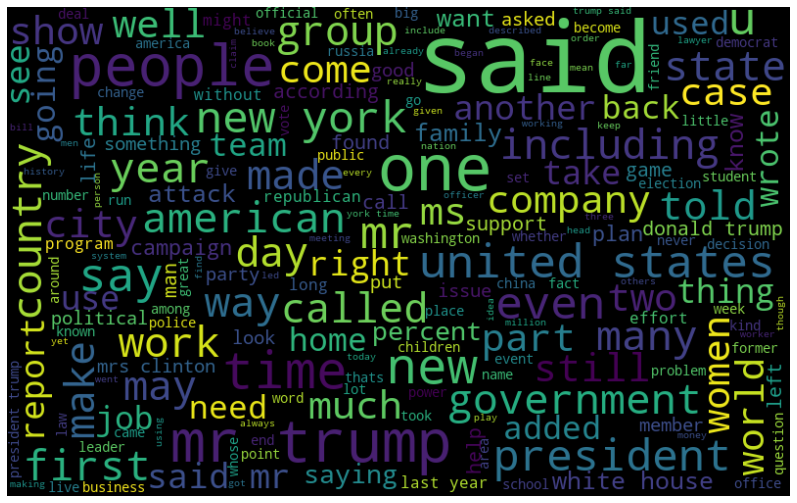

In [10]:
# visualize the frequent words for genuine news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

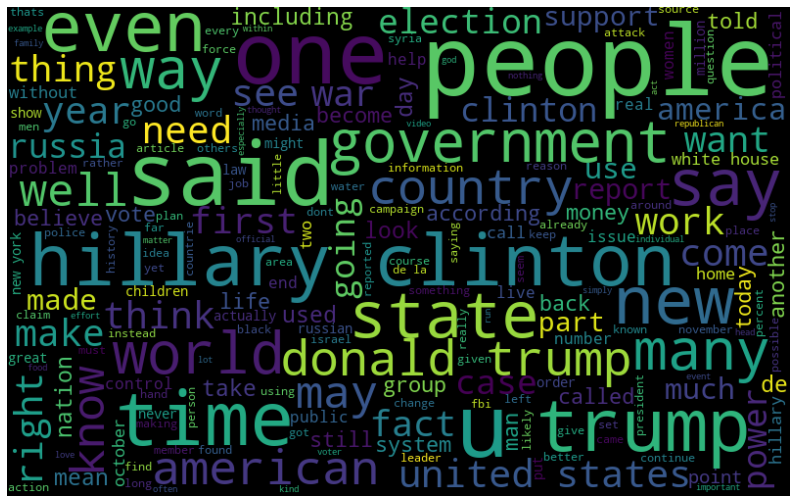

In [11]:
# visualize the frequent words for fake news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [13]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_news'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

121308

In [14]:
# padding data
sequences = tokenizer.texts_to_sequences(df['clean_news'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [15]:
# create embedding index
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [16]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [17]:
embedding_matrix[1]

array([-0.13128   , -0.45199999,  0.043399  , -0.99798   , -0.21053   ,
       -0.95867997, -0.24608999,  0.48413   ,  0.18178   ,  0.47499999,
       -0.22305   ,  0.30063999,  0.43496001, -0.36050001,  0.20245001,
       -0.52594   , -0.34707999,  0.0075873 , -1.04970002,  0.18673   ,
        0.57369   ,  0.43814   ,  0.098659  ,  0.38769999, -0.22579999,
        0.41911   ,  0.043602  , -0.73519999, -0.53583002,  0.19276001,
       -0.21961001,  0.42515001, -0.19081999,  0.47187001,  0.18826   ,
        0.13357   ,  0.41839001,  1.31379998,  0.35677999, -0.32172   ,
       -1.22570002, -0.26635   ,  0.36715999, -0.27586001, -0.53245997,
        0.16786   , -0.11253   , -0.99958998, -0.60706002, -0.89270997,
        0.65156001, -0.88783997,  0.049233  ,  0.67110997, -0.27553001,
       -2.40050006, -0.36989   ,  0.29135999,  1.34979999,  1.73529994,
        0.27000001,  0.021299  ,  0.14421999,  0.023784  ,  0.33643001,
       -0.35475999,  1.09210002,  1.48450005,  0.49430001,  0.15

In [18]:
padded_seq[1]

array([   12,   425, 65648,   532,  7818,  2079,  2107,  1542,  1507,
        1104,   660,   478,   194,    12,   394, 11237,  9599, 13323,
        8905,    95,    97, 20003,  9429, 10800, 14083,  8046,   321,
           7,   152,   787,   482,   354,   110, 40962,  2510, 19161,
        1067, 12447,  7288,  3433,  8273,     5,   764,   201,   477,
       15837,   426,    61,   533,   220,     1,   442,  1067,   442,
        1020,  1067,     9,    35,   313,   271,    10,   453,  2759,
        2498,  8273,   347,   763,   645,   184,    19, 20985,   728,
         285,     8,   173,  3705,    64, 10603,   733,  2703,    17,
         816,  5181,   159,    35,    53,  8905,    98,   319,  2704,
         496,   948,   349,  1443,  1361,   496,   948,   232,   988,
        1909,   349,   331,  5036,  6329, 17603,  5432,   151, 40963,
        6992,  1358,   643,   187, 11933,   179,   205,    41,    67,
           3,    97, 11238,  1507,   209,   406,   944,   980,   143,
         192,   588,

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_seq, df['label'], test_size=0.20, random_state=42, stratify=df['label'])

In [21]:
from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential



model = Sequential([
    Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
    Dropout(0.2),
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    Dense(256),
    Dense(1, activation='sigmoid')
])



2022-04-26 16:15:11.534877: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         12130900  
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [23]:
# train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/10
58/58 [==============================] - 144s 2s/step - loss: 0.5352 - accuracy: 0.7357 - val_loss: 0.4677 - val_accuracy: 0.7941
Epoch 2/10
58/58 [==============================] - 156s 3s/step - loss: 0.4448 - accuracy: 0.7982 - val_loss: 0.4861 - val_accuracy: 0.7892
Epoch 3/10
58/58 [==============================] - 159s 3s/step - loss: 0.4303 - accuracy: 0.8095 - val_loss: 0.3845 - val_accuracy: 0.8343
Epoch 4/10
58/58 [==============================] - 156s 3s/step - loss: 0.3798 - accuracy: 0.8383 - val_loss: 0.3756 - val_accuracy: 0.8419
Epoch 5/10
58/58 [==============================] - 167s 3s/step - loss: 0.3372 - accuracy: 0.8579 - val_loss: 0.3602 - val_accuracy: 0.8556
Epoch 6/10
58/58 [==============================] - 155s 3s/step - loss: 0.3282 - accuracy: 0.8588 - val_loss: 0.3885 - val_accuracy: 0.8269
Epoch 7/10
58/58 [==============================] - 148s 3s/step - loss: 0.3577 - accuracy: 0.8413 - val_loss: 0.3504 - val_accuracy: 0.8559
Epoch 8/10
58

In [30]:
score, acc = model.evaluate(x_test, y_test,verbose=2, batch_size= 512)
print('test accuracy:', acc)

8/8 - 8s - loss: 0.3438 - accuracy: 0.8674 - 8s/epoch - 961ms/step
test accuracy: 0.8673776388168335
